# Part 1: Data Setup

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/03 02:12:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
! wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
! wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
! wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip

--2023-04-03 02:12:24--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip’

hdma-wi-2021.zip    100%[===================>]  20.50M  48.9MB/s    in 0.4s    

2023-04-03 02:12:25 (48.9 MB/s) - ‘hdma-wi-2021.zip’ saved [21494278/21494278]

--2023-04-03 02:12:25--  https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.07s   

2023-04-03 02:12:25 (1.88 MB/s)

In [4]:
import zipfile, os

zip_files = os.listdir()
for file in zip_files:
    if ".zip" in file:
        with zipfile.ZipFile(file, 'r') as read_zip:
            for file_name in read_zip.namelist():
                read_zip.extract(file_name)
                print(f"extracting {file_name}")
                ! hdfs dfs -D dfs.replication=1 -cp {file_name} hdfs://main:9000/{file_name}
                ! rm {file_name} # removes files within zip file
            print(f"removing {file}")
            ! rm {file} # removes zip file
            print("done")

extracting arid2017_to_lei_xref_csv.csv
removing arid2017_to_lei_xref_csv.zip
done
extracting hdma-wi-2021.csv
removing hdma-wi-2021.zip
done
extracting action_taken.csv
extracting agency.csv
extracting counties.csv
extracting denial_reason.csv
extracting edit_status.csv
extracting ethnicity.csv
extracting hoepa.csv
extracting lien_status.csv
extracting loan_purpose.csv
extracting loan_type.csv
extracting msamd.csv
extracting owner_occupancy.csv
extracting preapproval.csv
extracting property_type.csv
extracting purchaser_type.csv
extracting race.csv
extracting sex.csv
extracting states.csv
extracting tracts.csv
removing code_sheets.zip
done


In [5]:
# !hdfs dfs -ls hdfs://main:9000/

In [6]:
banks_df = (spark.read.format("csv")
         .option("header", True)
         .option("inferSchema", True)
         .load("hdfs://main:9000/arid2017_to_lei_xref_csv.csv")
         .write.saveAsTable("banks", mode = "overwrite"))

23/04/03 02:13:46 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/04/03 02:13:46 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/04/03 02:13:51 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/04/03 02:13:51 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.4
23/04/03 02:13:52 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/04/03 02:13:52 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/04/03 02:13:53 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/banks; Force to delete it.
23/04/03 02:13:53 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/banks
23/04/03 02:14:00 WARN Sessio

In [7]:
loans_df = (spark.read.format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://main:9000/hdma-wi-2021.csv")
            .write.bucketBy(8, "county_code").saveAsTable("loans", mode = "overwrite"))

23/04/03 02:14:13 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
23/04/03 02:14:14 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/loans; Force to delete it.
23/04/03 02:14:14 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/loans
23/04/03 02:14:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
code_sheets = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for code in code_sheets:
    df = (spark.read.format("csv")
          .option("header", True)
          .option("inferSchema", True)
          .load(f"hdfs://main:9000/{code}.csv")
          .createOrReplaceTempView(code))

# Part 2: Filter and Join

In [9]:
# Q1: what tables are in our warehouse?
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [10]:
# Q2: how many banks contain the word "first" in their name? Which ones contain "second"?
first_count = spark.sql("""
SELECT respondent_name
FROM banks
WHERE LOWER(respondent_name) LIKE '%first%'
""").count()

second_banks = list(spark.sql("""
SELECT respondent_name
FROM banks
WHERE LOWER(respondent_name) LIKE '%second%'
""").toPandas()["respondent_name"])

print("Num. of banks that contain the word \"first\":", first_count) 
print("Banks that contan the word \"second\":", second_banks)

Num. of banks that contain the word "first": 525
Banks that contan the word "second": ['Old Second National Bank']


In [11]:
# Q3: how many loan applications has your "favorite" bank received in the dataset?

# for bank in set(banks.toPandas()["respondent_name"]):
#     if "wells fargo" in bank.lower():
#         print(bank)

# Favorite bank: JPMorgan Chase Bank, National Association
fav_bank = "JPMorgan Chase Bank, National Association"

banks = spark.table("banks")
loans = spark.table("loans")
banks_loans_joined = banks.join(loans, on=banks["lei_2020"] == loans["lei"], how = "inner")
chase_loans = banks_loans_joined.where(banks_loans_joined["respondent_name"] == fav_bank)
print(f"JPMorgan Chase Bank, National Association has received {chase_loans.count()} loans in this dataset.")

JPMorgan Chase Bank, National Association has received 8178 loans in this dataset.


In [12]:
# Q4: what does results.explain("formatted") tell us about Spark's query plan for Q3?
chase_loans.explain("formatted")

# 1. which table is sent to every executor via a BroadcastExchange operation?
# ANSWER: banks, because following "BroadcastExchange (3)" in the Physical Plan leads to (3) BroadcastExchange,
# where the inputs are all of the banks table columns.

# 2. on which tables is "is not null" filtering added by the optimizer?
# ANSWER: banks and loans (both tables being joined)

# 3. does the plan involve HashAggregates (depending on how you write the query, it may or may not)? If so, which ones?
# ANSWER: no it does not

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildLeft (6)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan parquet default.banks (1)
   +- Filter (5)
      +- Scan parquet default.loans (4)


(1) Scan parquet default.banks
Output [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,JPMorgan Chase Bank, National Association), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Condition : ((isnotnull(respondent_name#947) AND (respondent_name#947 = JPMorgan Chase Bank, National Association)) AND isnotnull(lei_2020#951))

(3) BroadcastExchange
Input [5]: [respondent_name#947, arid_2017#948,

In [13]:
# Q5: what are the top 10 biggest loans (in terms of loan_amount) that were approved by your favorite bank?
from pyspark.sql.functions import lower, col, expr, asc, desc, count, mean, concat_ws, lpad, when

chase_loans = (chase_loans
 .withColumn("thousands", col("loan_amount")/1000)
 .withColumn("years", col("loan_term")/12))

counties = (spark.table("counties")
           .select(col("STATE"), col("COUNTY"), col("NAME"))
           .distinct()
           .withColumn("code", concat_ws("", lpad(col("STATE"), 2, "0"), lpad(col("COUNTY"), 3, "0"))))

joined_counties = chase_loans.join(counties, on=chase_loans["county_code"] == counties["code"], how = "left")
joined_purpose = joined_counties.join(spark.table("loan_purpose"), on = joined_counties["loan_purpose"] == spark.table("loan_purpose")["id"], how = "left")
joined_all = joined_purpose.join(spark.table("action_taken"), on = joined_purpose["action_taken"] == spark.table("action_taken")["id"], how = "left")
                                                   
top_10 = (joined_all
          .select(col("census_tract"), col("NAME"), col("loan_purpose.loan_purpose"), col("derived_dwelling_category"), col("thousands"), col("interest_rate"), col("years"), col("action_taken.action_taken"))
          .withColumnRenamed("NAME", "county")
          .filter(col("action_taken") == "Loan originated")
          .orderBy(col("thousands").desc())).limit(10)
                                 
top_10.toPandas()

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55133203500,Waukesha,None,Single Family (1-4 Units):Site-Built,12915.0,2.75,30.0,Loan originated
1,55059000100,Kenosha,None,Multifamily:Site-Built,4975.0,3.38,30.0,Loan originated
2,55079012800,Milwaukee,None,Multifamily:Site-Built,4605.0,3.36,30.0,Loan originated
3,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,4555.0,2.75,30.0,Loan originated
4,55079185400,Milwaukee,None,Multifamily:Site-Built,3625.0,4.94,20.5,Loan originated
5,55127001602,Walworth,Home purchase,Single Family (1-4 Units):Site-Built,3535.0,2.875,30.0,Loan originated
6,55133204100,Waukesha,None,Single Family (1-4 Units):Site-Built,3305.0,2.625,30.0,Loan originated
7,55079019400,Milwaukee,None,Multifamily:Site-Built,3105.0,3.48,25.0,Loan originated
8,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,3005.0,3.125,30.0,Loan originated
9,55133203500,Waukesha,Home purchase,Single Family (1-4 Units):Site-Built,3005.0,2.25,30.0,Loan originated


# Part 3: GROUP BY and Windowing

In [14]:
# Q6: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?

county_group = spark.table("loans").groupby("county_code").agg(expr("AVG(loan_amount)"))
lei_group = spark.table("loans").groupby("lei").agg(expr("AVG(loan_amount)"))

county_group.explain("formatted")
lei_group.explain("formatted")

# we require network I/O between the partial_mean and mean operation for the groupby of the lei,
# because county_code was bucketed when it was originally loaded in and lei was not. 

# This is because bucketing places all of the bucketed data on the same worker node, skipping the network
# exchange when grouping.

# "(3) Exchange" appears in the output of .explain() for the grouping of the lei groupby,
# but not for the county_code groupby

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [county_code#969, loan_amount#986]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,loan_amount:double>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#969, loan_amount#986]
Keys [1]: [county_code#969]
Functions [1]: [partial_avg(loan_amount#986)]
Aggregate Attributes [2]: [sum#2818, count#2819L]
Results [3]: [county_code#969, sum#2820, count#2821L]

(3) HashAggregate
Input [3]: [county_code#969, sum#2820, count#2821L]
Keys [1]: [county_code#969]
Functions [1]: [avg(loan_amount#986)]
Aggregate Attributes [1]: [avg(loan_amount#986)#2613]
Results [2]: [county_code#969, avg(loan_amount#986)#2613 AS AVG(loan_amount)#2612]

(4) AdaptiveSparkPlan
Output [2]: [county_code#969, AVG(loan_amount)#2612]
Arguments: isFinalPlan

<Axes: xlabel='NAME'>

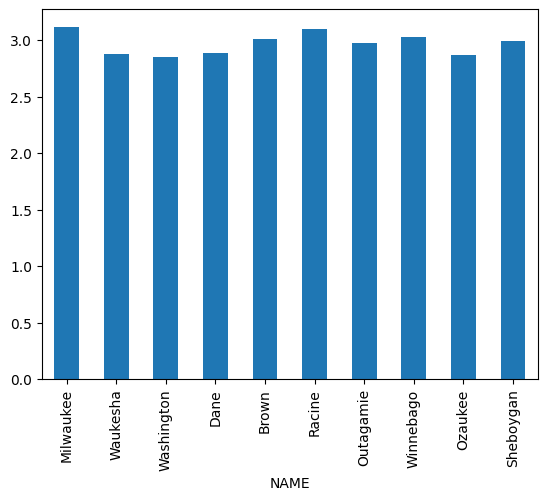

In [15]:
# Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?
wells_fargo = banks_loans_joined.where(banks_loans_joined["respondent_name"] == "Wells Fargo Bank, National Association")
wf_plus_counties = wells_fargo.join(counties, on = wells_fargo["county_code"] == counties["code"], how = "left")

wf_avg_interest = (wf_plus_counties
              .groupBy('NAME')
              .agg(expr("AVG(interest_rate)").alias('avg_interest_rate')))

wf_top_10 = (wf_plus_counties
 .groupby("NAME")
 .count()
 .orderBy(col("count").desc()))

wf_county_avg = (wf_top_10
                 .join(wf_avg_interest, on = ["NAME"], how = "inner")
                 .orderBy(col("count").desc())
                 .limit(10)
                ).toPandas()
plot_df = wf_county_avg.drop(["count"], axis = 1)
plot_df.set_index("NAME").plot.bar(legend=None)

Text(0, 0.5, '2nd Biggest Loan Application (Millions $)')

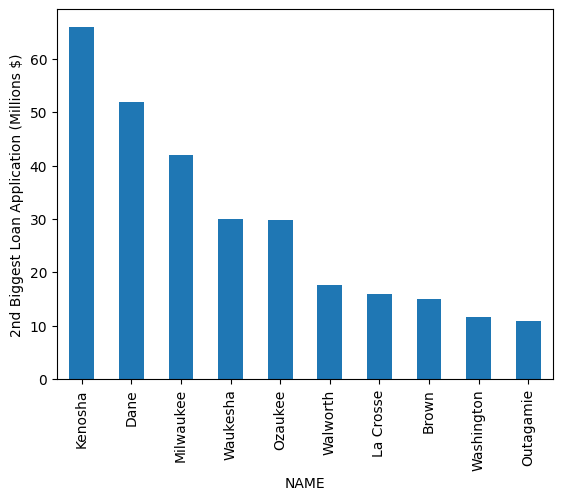

In [16]:
# Q8: what is the second biggest loan application amount in each county? (answer for top 10 counties).
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

banksloans_counties = banks_loans_joined.join(counties, on = banks_loans_joined["county_code"] == counties["code"], how = "inner")

window_spec = Window.partitionBy("NAME").orderBy(desc(col("loan_amount")))
ranked_loans = banksloans_counties.withColumn("rank", rank().over(window_spec))
second_biggest_loans = ranked_loans.filter(col("rank") == 2)
max_loan_amounts = second_biggest_loans.groupBy("NAME").max("loan_amount")
top_counties = max_loan_amounts.orderBy(desc("max(loan_amount)")).limit(10)

top_counties_pd = top_counties.toPandas()
top_counties_pd["max(loan_amount)"] = top_counties_pd["max(loan_amount)"] / (1000**2)
plt = top_counties_pd.set_index("NAME").plot.bar(legend=None)
plt.set_ylabel("2nd Biggest Loan Application (Millions $)")

# Part 4: Caching 

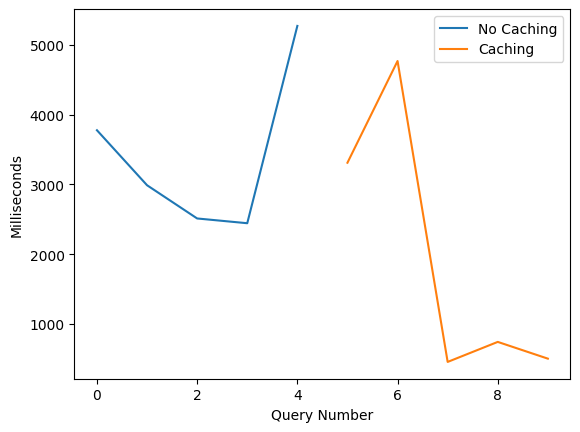

In [17]:
# Q9: what is the cost of caching and the impact on subsequent queries?
import time
import matplotlib.pyplot as plt

cache_df = spark.sql("""
SELECT interest_rate
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")

query_cache = {}

for i in range(10):
    start = time.time()
    cache_df.count()
    if i < 5:
        end = time.time()
        query_cache[i] = ((end - start) * 1000)
        continue
    if i == 5:
        cache_df.cache()
        end = time.time()
        query_cache[i] = ((end - start) * 1000)
        continue
    else:
        end = time.time()
        query_cache[i] = ((end - start) * 1000)
        continue
        
cache_df.unpersist()

no_caching_queries = list(query_cache.keys())[:5]
caching_queries = list(query_cache.keys())[5:]
no_caching = list(query_cache.values())[:5]
caching = list(query_cache.values())[5:]

plt.plot(no_caching_queries, no_caching, label = "No Caching")
plt.plot(caching_queries, caching, label = "Caching")
plt.xlabel("Query Number")
plt.ylabel("Milliseconds")
plt.legend()
plt.show()

23/04/03 02:17:36 WARN CacheManager: Asked to cache already cached data.


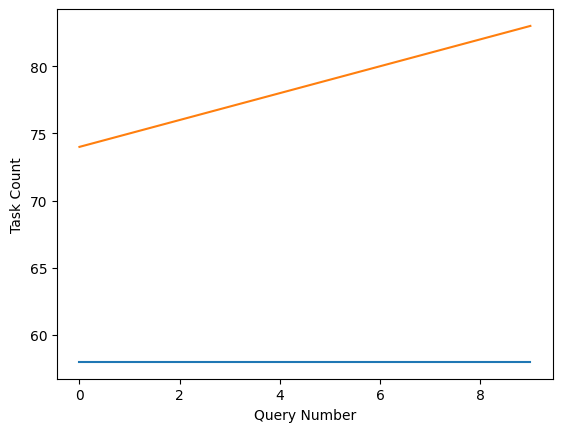

In [19]:
# Q10: what is the impact of caching a single partition on load balance?
import requests

repartitioned = cache_df.repartition(1)
repartitioned.cache()

id_resp = requests.get("http://localhost:4040/api/v1/applications")
id_resp.raise_for_status()

app_id = id_resp.json()[0]["id"]

executor_1 = []
executor_2 = [] 

for i in range(10):
    repartitioned.count()
    executors = requests.get(f"http://localhost:4040/api/v1/applications/{app_id}/executors")
    executors.raise_for_status()
    executor_1.append(executors.json()[1]["completedTasks"])
    executor_2.append(executors.json()[2]["completedTasks"])
    
plt.plot(executor_1)
plt.plot(executor_2)
plt.xlabel("Query Number")
plt.ylabel("Task Count")
plt.show()